In [1]:
import melign

In [2]:
dataset = melign.Dataset("dataset_v1.2")

In [3]:
melign.dev.data.prepare_candidates(
    dataset, "candidates",
    miss_tolerance=2,
    hop_length=1,
    min_length=5,
    n_jobs=12)

Processing songs (n_jobs=12):   0%|          | 0/36 [00:00<?, ?it/s]

Candidate statistics: avg=227640.42, min=59869, max=901352


In [4]:
melign.dev.data.score_candidates(
    dataset, "candidates_test", "sheets_test",
    min_length=8, n_sample=20000, n_jobs=6)

Scoring candidates (n_jobs=6):   0%|          | 0/187 [00:00<?, ?it/s]

Song <倔强(五月天)> generated an exception: 'Alignment' object is not iterable
Song <都怪我(胡66)> generated an exception: 'Alignment' object is not iterable


In [3]:
df = melign.dev.get_regression_dataframe(dataset, "sheets_test")

Concatenating sheets:   0%|          | 0/187 [00:00<?, ?it/s]

d:\code\exmel\melign\dev\regression.py:24: UserWarning: File sheets_test\倔强(五月天).xlsx doesn't exist, skipping...
  warnings.warn(f"File {file} doesn't exist, skipping...")
d:\code\exmel\melign\dev\regression.py:24: UserWarning: File sheets_test\都怪我(胡66).xlsx doesn't exist, skipping...
  warnings.warn(f"File {file} doesn't exist, skipping...")


Number of samples: 3700000
=== Model Performance ===
Training R² Score: 0.9989
Testing R² Score: 0.9971
Training MSE: 1.9657
Testing MSE: 5.2028
Training MAE: 0.9012
Testing MAE: 1.3649
Training RMSE: 1.4020
Testing RMSE: 2.2810


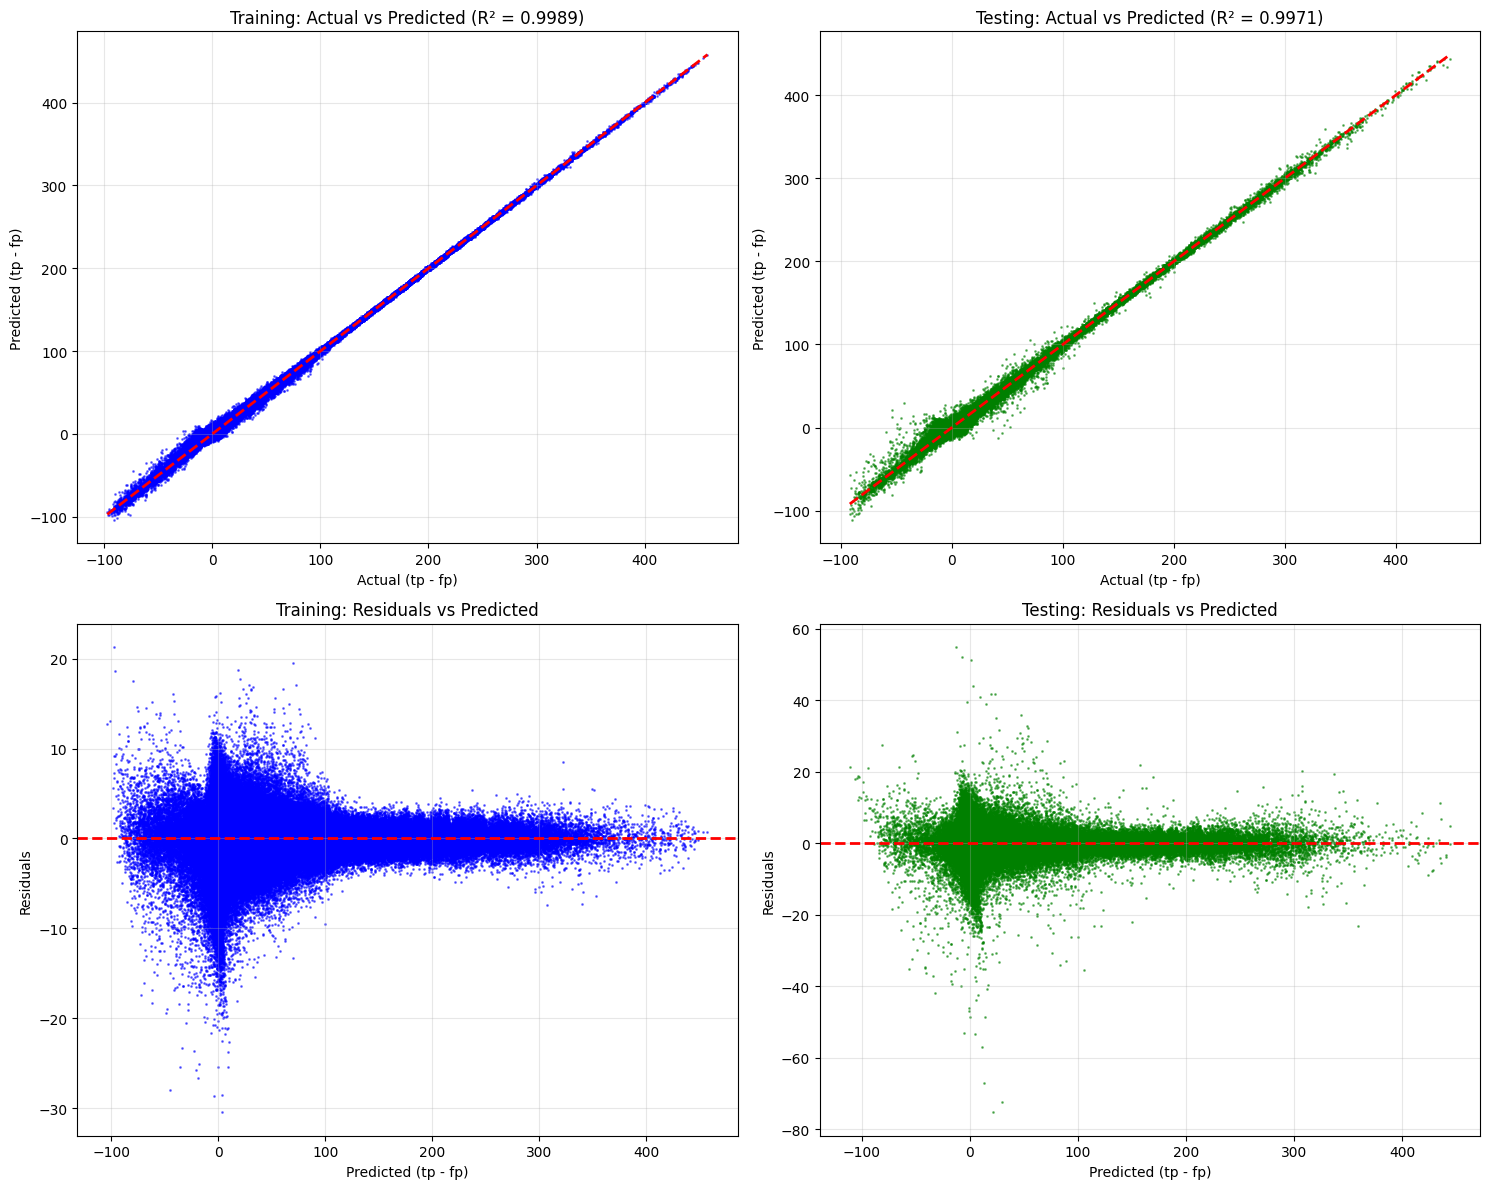

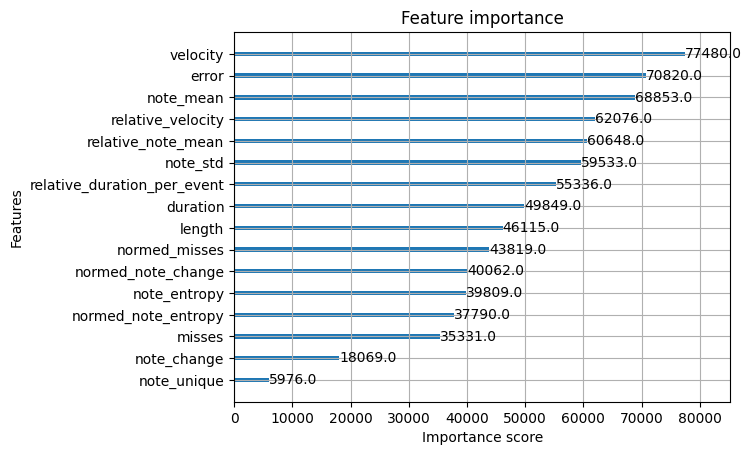

In [5]:
melign.dev.train_model(df, "xgb_testset.json")

In [3]:
from itertools import product

evmnsba = list(product(
    (0, 0.5),
    (True, False),
    (True, False),
    (True, False),
    (True, False),
    (True, False),
    (True, False),
))

In [4]:
results: dict[tuple[float, bool, bool, bool, bool, bool, bool], melign.dev.min_score.Result] = {}
from tqdm.auto import tqdm

for e, v, m, n, s, b, a in tqdm(evmnsba, desc="Searching best weights"):
    weights: melign.align.score.MelodicsWeights = {
        "error": e,
        "velocity": v,
        "miss": m,
        "note_mean": n,
        "shadow": s,
        "between": b,
        "above_between": a,
    }
    score_model = melign.align.score.MelodicsModel(weights)
    _, best = melign.dev.search_min_score(
        dataset=dataset,
        candidates_dir="candidates",
        min_length=5,
        search_range=range(3, 13),
        score_model=score_model,
        verbose=False,
        n_jobs=12
    )
    results[(e, v, m, n, s, b, a)] = best

Searching best weights:   0%|          | 0/128 [00:00<?, ?it/s]

In [8]:
best_f1 = max(r["f1"] for r in results.values())
for k, r in results.items():
    if r["f1"] == best_f1:
        print(k, r)
        break

(0.5, True, True, False, True, False, True) {'min_score': 4, 'f1': 0.953925744898644, 'precision': 0.9803033043779056, 'recall': 0.9301702918110561}


In [9]:
weights: melign.align.score.MelodicsWeights = {
        "error": 0.5,
        "velocity": True,
        "miss": True,
        "note_mean": False,
        "shadow": True,
        "between": False,
        "above_between": True,
    }
score_model = melign.align.score.MelodicsModel(weights)

In [12]:
results = melign.dev.search_min_score(
    dataset=dataset,
    candidates_dir="candidates",
    min_length=5,
    search_range=(3, 3.25, 3.5, 3.75, 4),
    score_model=score_model,
    verbose=True,
    n_jobs=6
)

Min score (n_jobs=6):   0%|          | 0/36 [00:00<?, ?it/s]

In [13]:
results

(defaultdict(<function melign.dev.min_score.search_min_score.<locals>.<lambda>()>,
             {3: {'f1': 0.9522240645770721,
               'precision': 0.9642569579663779,
               'recall': 0.9417611383330036},
              3.25: {'f1': 0.953639419444918,
               'precision': 0.9697281450336689,
               'recall': 0.9392242661364493},
              3.5: {'f1': 0.9552629887521937,
               'precision': 0.9749902255068472,
               'recall': 0.9372841998661184},
              3.75: {'f1': 0.9551678114082567,
               'precision': 0.9779905514205556,
               'recall': 0.9344588876166384},
              4: {'f1': 0.953925744898644,
               'precision': 0.9803033043779056,
               'recall': 0.930170291811056}}),
 {'min_score': 3.5,
  'f1': 0.9552629887521937,
  'precision': 0.9749902255068472,
  'recall': 0.9372841998661184})